In [1]:
# This notebook illustrates the halfar ice model

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt

RESOURCES = os.path.join(
   os.getcwd(), "../resources"
)
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "halfar")

[20.00000, 20.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-12-29 16:25:17,211 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2023-12-29 16:25:19,380 - funman.api.run - INFO - Dumping results to ./out/0e140512-2416-4ef9-9162-7fdbbf4e44cb.json
2023-12-29 16:25:26,583 - funman.search.box_search - INFO - progress: 0.05000
2023-12-29 16:25:26,788 - funman.search.box_search - INFO - progress: 0.10000
2023-12-29 16:25:27,002 - funman.search.box_search - INFO - progress: 0.15000
2023-12-29 16:25:27,224 - funman.search.box_search - INFO - progress: 0.20000
2023-12-29 16:25:27,460 - funman.search.box_search - INFO - progress: 0.25000
2023-12-29 16:25:27,716 - funman.search.box_search - INFO - progress: 0.30000
2023-12-29 16:25:27,987 - funman.search.box_search - INFO - progress: 0.35000
2023-12-29 16:25:28,278 - funman.search.box_search - INFO - progress: 0.40000
2023-12-29 16:25:28,59

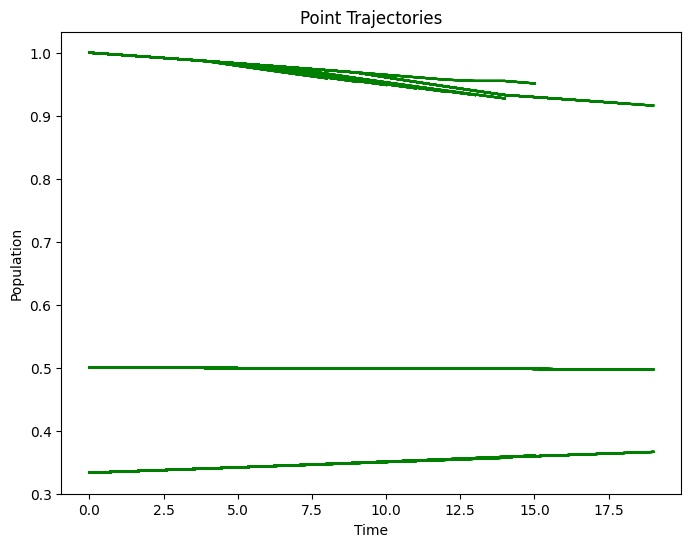

2023-12-29 16:25:39,163 - funman.api.run - INFO - Creating plot of parameter space: ./out/0e140512-2416-4ef9-9162-7fdbbf4e44cb_parameter_space.png


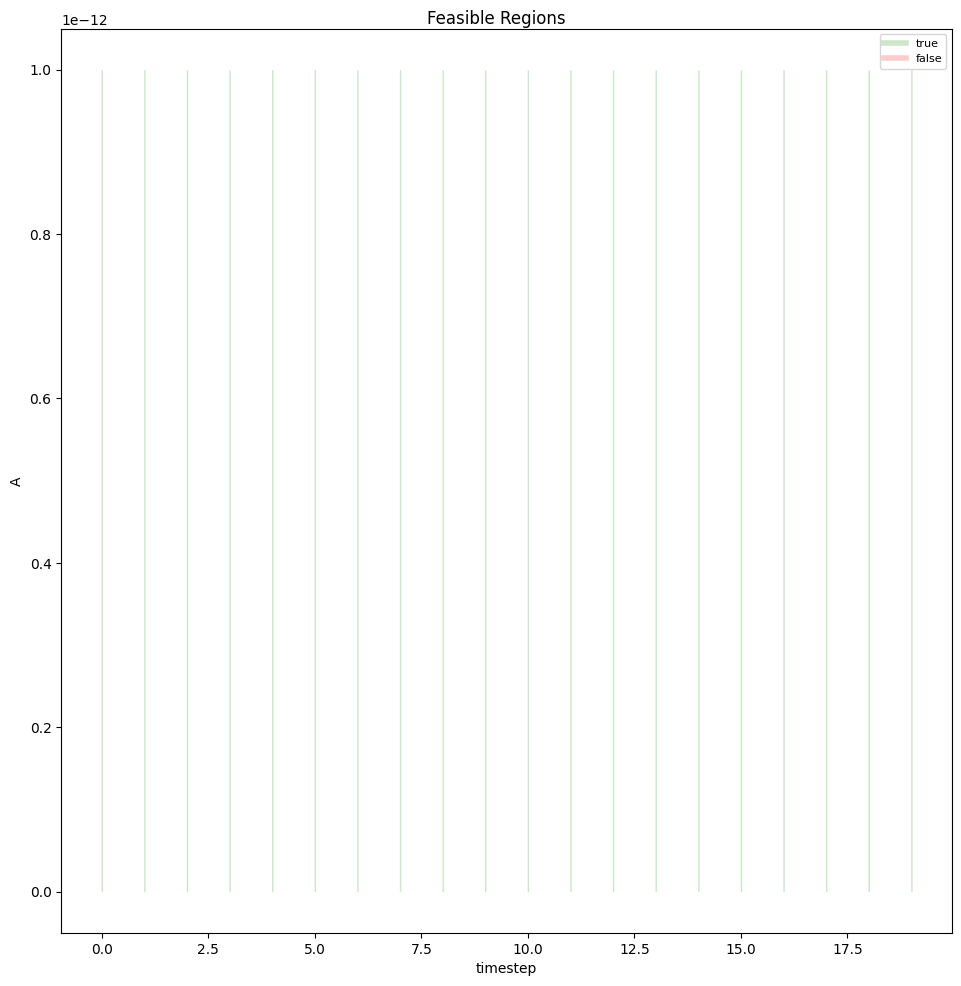

2023-12-29 16:25:39,928 - funman.server.worker - INFO - Completed work on: 0e140512-2416-4ef9-9162-7fdbbf4e44cb
2023-12-29 16:25:49,439 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2023-12-29 16:25:49,497 - funman.server.worker - INFO - FunmanWorker exiting...
2023-12-29 16:25:49,503 - funman.server.worker - INFO - Worker.stop() completed.
2023-12-29 16:25:49,505 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2023-12-29 16:25:49,507 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2023-12-29 16:25:49,509 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - * Analysis Summary 
2023-12-29 16:25:49,511 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - *

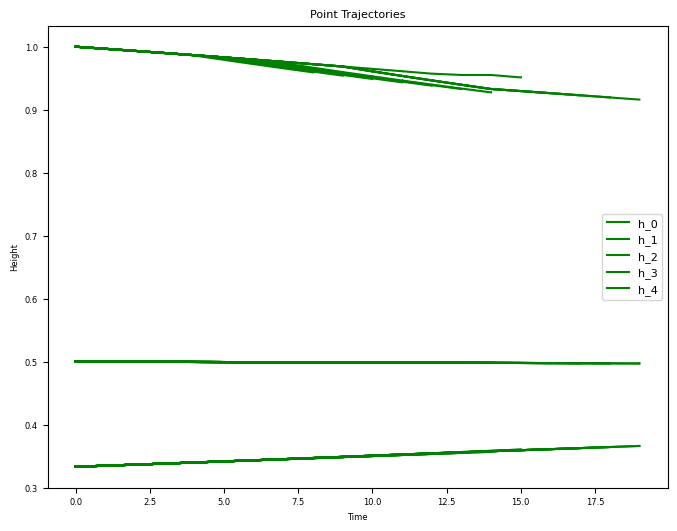

In [2]:
# 1x5 model

MODEL_PATH = os.path.join(EXAMPLE_DIR, f"halfar_1x5_0_boundary.json")


# Create constraint pos_i on the height h at each location i
# pos_i: 0 <= h_i < 1.01, for i in [0, 4]
num_disc = 5
variables = [f"h_{d}" for d in range(num_disc)]
height_bounds = [
            {"name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0, "ub": 1.01}
         }
    for i in variables
]

# Create request for the analysis
# structure_parameters: timepoints to evaluate 
# parameters: A, dt
# constraints: height bounds (above), slope on boundaries is well-formed
# config: uses defaults

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0,20, 1)}
            ],
        },
        
    ],
    "parameters":[
        {"name": "A",
         "label":"all",
         "interval": {"lb":1e-20, "ub":1e-12}
         },
        {"name": "dt",
         "label":"any",
         "interval": {"lb":20, "ub":20}
         }
    ],
    "constraints": height_bounds + 
    [
        {"name": "LHS_slope",
            "variables": ["h_1", "h_0"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }, 
        {"name": "RHS_slope",
            "variables": ["h_3", "h_4"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
        # "use_compartmental_constraints": False,
        # "normalization_constant": 1.0,
        # "tolerance": 1e-2,
        # "verbosity": 20,
        # "dreal_mcts": False,
        # "dreal_precision": 0.1,
        # "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        # "dreal_log_level": "info",
        # "profile": False,
    },
}


# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    description="Halfar 1x5 Demo",
    case_out_dir="./out",
    dump_plot=True,
    parameters_to_plot=["A", "timestep"],
    point_plot_config={
        # "variables":variables, 
        "label_marker":{"true":",", "false": ","},  
        # "xlabel":"Time", 
        # "ylabel":"Height", 
        # "legend":variables,
        # "label_color":{"true": "g", "false":"r"}
        },
    # num_points=None,
)

summarize_results(variables, results)

In [6]:
h, dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

In [15]:
# Use a five point 2d model 


MODEL_PATH = os.path.join("../", "resources/amr/halfar/halfar_5x5_0_boundary.json")

# Create constraint pos_i_j on the height h at each location i,j
# pos_i_j: 0 <= h_i_j < 1.01, for i in [0, 4] for j in [0, 4]
num_disc = 5
variables = [f"h_{d1}_{d2}" for d1 in range(num_disc) for d2 in range(num_disc)]
height_bounds = [
            {"name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0, "ub": 1.01}
         }
    for i in variables
]

pos_slope = [
    {"name": f"LHS_slope_0_{i}",
            "variables": [f"h_1_{i}", f"h_0_{i}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
    } 
    for i in range(1, num_disc-1)
] + [
    {"name": f"LHS_slope_1_{i}",
            "variables": [f"h_{i}_1", f"h_{i}_0"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
    } 
    for i in range(1, num_disc-1)
]

neg_slope = [
       {"name": f"RHS_slope_0_{i}",
            "variables": [f"h_{num_disc-2}_{i}", f"h_{num_disc-1}_{i}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
        for i in range(1, num_disc-1)
] + [
    {"name": f"RHS_slope_1_{i}",
            "variables": [f"h_{i}_{num_disc-2}", f"h_{i}_{num_disc-1}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
        for i in range(1, num_disc-1)
]

# Create request for the analysis
# structure_parameters: timepoints to evaluate 
# parameters: A, dt
# constraints: height bounds (above), slope on boundaries is well-formed
# config: uses defaults

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0,10, 1)}
            ],
        },
        
    ],
    "parameters":[
        {"name": "A",
         "label":"any",
        #  "interval": {"lb":1e-20, "ub":1e-12}}
         "interval": {"lb":1e-20, "ub":1e-12}}
        ,
        {"name": "dt",
         "label":"any",
         "interval": {"lb":50, "ub":50}
         }
    ],
    "constraints": height_bounds + pos_slope + neg_slope +
    [
        
     


    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
        # "use_compartmental_constraints": False,
        # "normalization_constant": 1.0,
        # "tolerance": 1e-3,
        "verbosity": 10,
        # "dreal_mcts": False,
        # "dreal_precision": 1,
        # "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        # "dreal_log_level": "info",
        # "profile": False,
    },
}


# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    # REQUEST_PATH,
    description="Halfar 5x5 demo",
    case_out_dir="./out",
    dump_plot=True,
    parameters_to_plot=["A", "timestep"],
    point_plot_config={
        # "variables":variables, 
        "label_marker":{"true":",", "false": ","},  
        # "xlabel":"Time", "ylabel":"Height", "legend":variables,"label_color":{"true": "g", "false":"r"}
        },
    # num_points=None,
    
)

summarize_results(variables, results)




2023-12-29 17:07:12,338 - funman.server.worker - INFO - FunmanWorker running...
[50.00000, 50.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-12-29 17:07:12,346 - funman.server.worker - INFO - Starting work on: 4421bd8d-a6b7-454d-b3f6-ae4ca19b2336
2023-12-29 17:07:12,348 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2023-12-29 17:07:14,359 - funman.api.run - INFO - Dumping results to ./out/4421bd8d-a6b7-454d-b3f6-ae4ca19b2336.json
2023-12-29 17:07:24,407 - funman.api.run - INFO - Dumping results to ./out/4421bd8d-a6b7-454d-b3f6-ae4ca19b2336.json
2023-12-29 17:07:28,872 - /home/danbryce/funman/src/funman/search/smt_check.py - DEBUG - Solving schedule: timepoints=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2023-12-29 17:07:28,873 - funman_dreal.solver - DEBUG - Created new Solver ...
2023-12-29 17:07:28,902 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 0 to

In [16]:
h, dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

2023-12-29 17:10:49,157 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff91f21c40>
2023-12-29 17:10:49,379 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8f446970>
2023-12-29 17:10:49,654 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffcddc1a00>
2023-12-29 17:10:50,225 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8edd2ac0>
2023-12-29 17:10:50,509 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8eada970>
2023-12-29 17:10:50,778 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffae50e1f0>
2023-12-29 17:10:51,048 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffce0b0790>
2023-12-29 17:10:51,350 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8e9c3b50>
2023-12-29 17:10:51,628 

In [17]:
# Advection Model

num_disc = 5


MODEL_PATH = os.path.join("..", f"resources/amr/advection/advection_5x5_centered_0_boundary.json")
# MODEL_PATH = os.path.join("..", f"resources/amr/advection/advection_5x5_forward_0_boundary.json")
# MODEL_PATH = os.path.join("..", f"resources/amr/advection/advection_5x5_backward_0_boundary.json")

# The energy at each location is non-negative

height_bounds = [
            {"name": f"pos_u_{i1}_{i2}",
         "variable": f"u_{i1}_{i2}",
         "interval": {"lb": 0}
         }
    for i1 in range(num_disc)
     for i2 in range(num_disc)
]

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0, 10, 1)}
            ],
        },
        
    ],
    "parameters":[
        # {"name": "dt",
        #  "label":"any",
        # #  "interval": {"lb":1e-18, "ub":1e-14}}
        # "interval": {"lb":1, "ub":1}},
        {"name": "dx",
         "label":"any",
        #  "interval": {"lb":1e-18, "ub":1e-14}}
        "interval": {"lb":1, "ub":1}},
        {"name": "a",
         "label":"any",
        #  "interval": {"lb":1e-18, "ub":1e-14}}
        "interval": {"lb":-1e-1, "ub":-1e-2}
        }
    ],
    "constraints": 
    #  height_bounds + 
    [

        # 0 <= dx - a
        # a <= dx
        # {"name": "dx_gte_a",
        #     "variables": ["dx", "a"],
        #     "weights": [1, -1],
        #     "additive_bounds": {"lb": 0},
        #     # "timepoints": {"lb": 0}
        # }, 
 

        ],
    "config": {
        # "use_compartmental_constraints": False,
        # "normalization_constant": 1.0,
        # "tolerance": 1e-2,
        # "verbosity": 5,
        # "dreal_mcts": True,
        # "dreal_precision": 1,
        "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        # "dreal_log_level": "trace",
        # "profile": False,
    },
}
# variables = [f"u_{d}" for d in range(num_disc)]
variables = [f"u_{d1}_{d2}" for d1 in range(num_disc) for d2 in range(num_disc)]

# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    # REQUEST_PATH,
    description="Advection demo",
    case_out_dir="./out",
    # dump_plot=True,
    # parameters_to_plot=["a", "dx", "timestep"],
    point_plot_config={"variables":variables, 
                    #    "label_marker":{"true":",", "false": ","},  "xlabel":"Time", "ylabel":"Height", "legend":variables
    #,"label_color":{"true": "g", "false":"r"}
    },
    num_points=None
)

point_plot = summarize_results(variables, results)
display(point_plot)
plt.close()

h, dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

2024-01-05 16:12:58,346 - funman.server.worker - INFO - FunmanWorker running...
[1.00000, 1.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-01-05 16:12:58,359 - funman.server.worker - INFO - Starting work on: 960507b6-276c-4289-88d4-b289ba441705
2024-01-05 16:12:58,363 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2024-01-05 16:13:00,366 - funman.api.run - INFO - Dumping results to ./out/960507b6-276c-4289-88d4-b289ba441705.json


2024-01-05 16:13:10,450 - funman.api.run - INFO - Dumping results to ./out/960507b6-276c-4289-88d4-b289ba441705.json
2024-01-05 16:14:05,432 - funman.api.run - INFO - Dumping results to ./out/960507b6-276c-4289-88d4-b289ba441705.json
2024-01-05 16:14:05,535 - funman.scenario.consistency - INFO - 9{9}:	[+]
2024-01-05 16:14:05,538 - funman.server.worker - INFO - Completed work on: 960507b6-276c-4289-88d4-b289ba441705
2024-01-05 16:14:15,537 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-01-05 16:14:15,548 - funman.server.worker - INFO - FunmanWorker exiting...
2024-01-05 16:14:15,551 - funman.server.worker - INFO - Worker.stop() completed.
2024-01-05 16:14:15,557 - /root/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2024-01-05 16:14:15,559 - /root/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - *************************************

None